# Example: Hilbert space approximation for Gaussian processes (multidimensional)


## Draw Simulated Data

In [2]:
import jax

jax.config.update("jax_enable_x64", True)  # very important

In [3]:
from numpy.typing import NDArray

from jax import random
import jax.numpy as jnp


def se_kernel(
    X: jax.Array,
    Z: jax.Array,
    amplitude: float,
    length: float,
    noise: float | None,
    jitter=1.0e-6,
) -> jax.Array:
    """Squared exponential kernel function."""
    r = jnp.linalg.norm(X[:, jnp.newaxis] - Z, axis=-1)
    delta = (r / length) ** 2
    k = (amplitude**2) * jnp.exp(-0.5 * delta)
    if noise is None:
        return k
    else:
        return k + (noise + jitter) * jnp.eye(k.shape[0])


def sample_grid_and_data(
    N_grid: int,
    N: int,
    L: float,
    amplitude: float,
    lengthscale: float,
    noise: float,
    key: int,
    D: int,
) -> tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
    """Sample N_grid ** D points from noiseless function and N noisy data points from a GP."""

    # draw points on a grid for plotting surface of the noiseless function
    x_linspace = jnp.linspace(-L, L, N_grid)
    x_mesh = jnp.meshgrid(*[x_linspace for _ in range(D)])
    X_grid = jnp.concatenate([x_mesh[i].ravel()[..., None] for i in range(D)], axis=1)

    # draw data points from a uniform distribution on the support of the grid
    X = random.uniform(key, shape=(N, D), minval=-L, maxval=L)

    # concatenate grid and data points
    X_all = jnp.concatenate([X_grid, X], axis=0)

    # sample from the GP
    cov = se_kernel(X_all, X_all, amplitude, lengthscale, 0.0)  # noiseless
    _, key = random.split(key)
    _y = random.multivariate_normal(key, mean=jnp.zeros(cov.shape[0]), cov=cov)

    # separate the grid and data points
    y_grid = _y[0 : N_grid**D].reshape((N_grid,) * D)
    _, key = random.split(key)
    y = _y[N_grid**D :] + (
        random.normal(key, shape=(N,)) * noise
    )  # add noise to the data points

    return X_grid, y_grid, X, y

In [15]:
# parameters for the synthetic data
D = 2
N_grid = 25 if D == 2 else 100
N = 1_000
L = 3.0
amplitude = 1.0
lengthscale = 2.0
noise = 0.5 if D == 2 else 0.15

# sample the grid and data
seed = 0
key = jax.random.key(seed)

X_grid, y_grid, X, y = sample_grid_and_data(
    N_grid, N, L, amplitude, lengthscale, noise, key, D
)

In [73]:
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np


def plot_surface_scatter(
    N_grid: int,
    X_grid: NDArray | None = None,
    y_grid: NDArray | None = None,
    X: NDArray | None = None,
    y: NDArray | None = None,
    test_ind: jax.Array | None = None,
    post_y: jax.Array | None = None,
    xz_lines: list[tuple[jax.Array, jax.Array, float]] | None = None,
    yz_lines: list[tuple[jax.Array, jax.Array, float]] | None = None,
    xy_annotate_lines: Sequence[
        tuple[tuple[float, float], tuple[float, float]] | None
    ] = None,
    fig_size: float = 8.0,
    label_size: float = 8.0,
    grid_alpha: float = 0.1,
    y_wireframe_alpha: float = 1.0,
    post_alpha: float = 0.1,
    point_size: float = 1.0,
    point_alpha: float = 0.5,
    ci_alpha: float = 0.1,
) -> None:
    # setup figure
    fig = plt.figure(figsize=(fig_size, fig_size))

    # plot the surface of the noiseless function and the data points
    x0_grid, x1_grid = (
        X_grid[:, 0].reshape((N_grid, N_grid)),
        X_grid[:, 1].reshape((N_grid, N_grid)),
    )
    ax = fig.add_subplot(projection="3d")

    if post_y is not None:
        for i in range(post_y.shape[0]):
            post_y_grid = post_y[i, :].reshape((N_grid, N_grid))
            ax.plot_wireframe(
                x0_grid,
                x1_grid,
                post_y_grid,
                rstride=1,
                cstride=1,
                linewidth=1.0,
                alpha=post_alpha,
                color="tab:blue",
            )
    if X is not None and y is not None:
        color = (
            "tab:blue"
            if test_ind is None
            else np.where(test_ind, "tab:green", "tab:blue")
        )
        ax.scatter(
            xs=X[:, 0],
            ys=X[:, 1],
            zs=y,
            c=color,
            s=point_size,
            alpha=point_alpha,
        )
    if xz_lines:
        for line in xz_lines:
            x, z, y = line
            ax.plot(
                x, z, zs=y, zdir="y", color="tab:green", linestyle="--", alpha=ci_alpha
            )
    if yz_lines:
        for line in yz_lines:
            y, z, x = line
            ax.plot(
                y, z, zs=x, zdir="x", color="tab:green", linestyle="--", alpha=ci_alpha
            )

    if y_grid is not None:
        ax.plot_wireframe(
            x0_grid,
            x1_grid,
            y_grid,
            rstride=1,
            cstride=1,
            linewidths=1.0,
            alpha=y_wireframe_alpha,
            color="tab:orange",
        )

    # add box in xy plane
    z_min = ax.get_zlim()[0]
    ax.set_zlim(ax.get_zlim())
    if xy_annotate_lines:
        for line in xy_annotate_lines:
            x_bounds, y_bounds = line
            z_bounds = (z_min, z_min)
            ax.plot(
                x_bounds,
                y_bounds,
                z_bounds,
                color="tab:gray",
                alpha=0.5,
                linestyle="--",
            )

    # remove background panes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor("w")
    ax.yaxis.pane.set_edgecolor("w")
    ax.zaxis.pane.set_edgecolor("w")

    # configure grid
    ax.xaxis._axinfo["grid"]["color"] = ("tab:gray", grid_alpha)
    ax.yaxis._axinfo["grid"]["color"] = ("tab:gray", grid_alpha)
    ax.zaxis._axinfo["grid"]["color"] = ("tab:gray", grid_alpha)

    # set labels and ticks
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.set_xlabel("x0", fontsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.set_ylabel("x1", fontsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    ax.set_zlabel("y", fontsize=label_size)

    ax.set_box_aspect(aspect=None, zoom=0.9)
    return ax


def plot_line_scatter(
    X_grid: jax.Array,
    y_grid: jax.Array,
    X: jax.Array | None = None,
    y: jax.Array | None = None,
    test_ind: jax.Array | None = None,
    post_y: jax.Array | None = None,
    v_lines: Sequence[float] | None = None,
    ci: tuple[jax.Array, jax.Array] | None = None,
    fig_size: float = 5.0,
    label_size: float = 8.0,
    post_alpha: float = 0.25,
    point_size: float = 1.0,
    point_alpha: float = 0.25,
    ci_alpha: float = 0.1,
):
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot()

    if post_y is not None:
        for i in range(post_y.shape[0]):
            ax.plot(
                X_grid, post_y[i, :], linewidth=1.0, alpha=post_alpha, color="tab:blue"
            )
    if X is not None and y is not None:
        if test_ind is None:
            color = "tab:blue"
        else:
            test_ind = np.array(test_ind).squeeze()
            color = np.where(test_ind, "tab:green", "tab:blue")
        ax.scatter(X, y, c=color, s=point_size, alpha=point_alpha)
    if ci:
        ax.fill_between(
            X_grid.squeeze(), ci[0], ci[1], color="tab:blue", alpha=ci_alpha
        )
    ax.plot(X_grid, y_grid, linewidth=1.0, alpha=1.0, color="tab:orange")

    if v_lines:
        for v_line in v_lines:
            plt.axvline(v_line, color="tab:gray", linestyle="--", alpha=0.5)
            plt.axvline(v_line, color="tab:gray", linestyle="--", alpha=0.5)

    ax.set_xlabel("x", fontsize=label_size)
    ax.set_ylabel("y", fontsize=label_size)
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)

    return ax

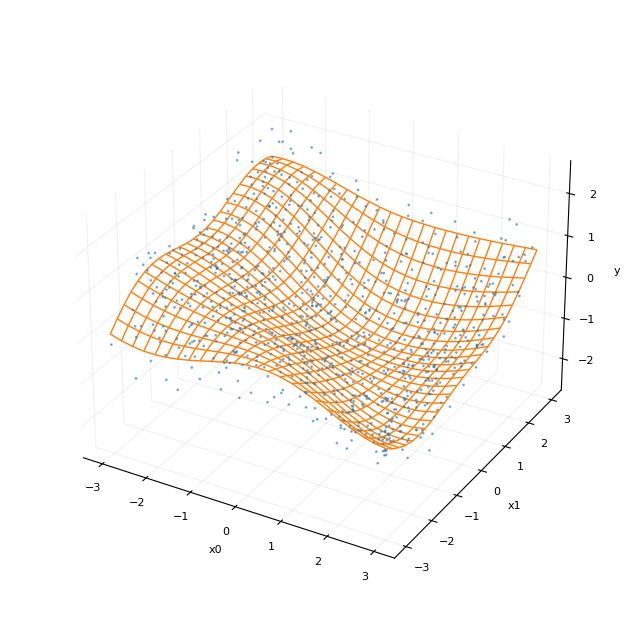

In [74]:
if D == 2:
    plot_surface_scatter(N_grid, X_grid, y_grid, X, y)
elif D == 1:
    plot_line_scatter(
        X_grid,
        y_grid,
        X,
        y,
    )
plt.show()

## Full Rank GP Baseline

In [18]:
from optax import linear_onecycle_schedule

import numpyro
from numpyro import distributions as dist


@jax.tree_util.register_pytree_node_class  # https://github.com/google/jax/discussions/16020
class GPModel:
    def __init__(self, X: jax.Array, y: jax.Array):
        self.X = X
        self.y = y

    def model(self, X_test: jax.Array | None = None):
        amplitude = numpyro.sample("amplitude", dist.LogNormal(0, 1))
        length = numpyro.sample("lengthscale", dist.Exponential(1))
        noise = numpyro.sample("noise", dist.LogNormal(0, 1))

        k = se_kernel(self.X, self.X, amplitude, length, noise)

        if X_test is not None:
            k_inv = jnp.linalg.inv(k)
            k_star = se_kernel(X_test, self.X, amplitude, length, noise=None)
            k_star_star = se_kernel(X_test, X_test, amplitude, length, noise)

            f_star = numpyro.deterministic("f_star", k_star @ (k_inv @ self.y))
            cov_star = k_star_star - (k_star @ k_inv @ k_star.T)
            numpyro.sample(
                "y_test",
                dist.MultivariateNormal(loc=f_star, covariance_matrix=cov_star),
            )
        else:
            numpyro.sample(
                "y", dist.MultivariateNormal(loc=0, covariance_matrix=k), obs=self.y
            )

    def tree_flatten(self):
        children = (self.X, self.y)  # arrays / dynamic values
        aux_data = {}  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

In [82]:
tr_frac = 0.8
tr_idx = ((X > -L * tr_frac) & (X < L * tr_frac)).sum(axis=1) == D
tr_idx_grid = ((X_grid > -L * tr_frac) & (X_grid < L * tr_frac)).sum(axis=1) == D
X_tr = X[tr_idx]  # train on values set away from the edges
X_test = X[~tr_idx]
y_tr = y[tr_idx]
y_test = y[~tr_idx]

m = GPModel(X_tr, y_tr)

In [20]:
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.elbo import Trace_ELBO
from numpyro.infer.initialization import init_to_median
from numpyro.infer.svi import SVI
from numpyro.optim import Adam

# TODO MCMC alternative


def fit_svi(
    seed: int,
    model: callable,
    guide: callable,
    num_steps: int = 1000,
    peak_lr: float = 0.01,
    **model_kwargs,
):
    lr_scheduler = linear_onecycle_schedule(num_steps, peak_lr)
    svi = SVI(model, guide, Adam(lr_scheduler), Trace_ELBO())
    return svi.run(random.PRNGKey(seed), num_steps, **model_kwargs)


guide = AutoNormal(m.model, init_loc_fn=init_to_median(num_samples=25))
res = fit_svi(seed=seed, model=m.model, guide=guide)

100%|██████████| 1000/1000 [00:53<00:00, 18.63it/s, init loss: 889.5326, avg. loss [951-1000]: 511.5594]


In [21]:
from numpyro.infer import Predictive


def posterior_predictive_svi(
    seed: int,
    model: callable,
    guide: callable,
    params: dict,
    num_samples: int = 5000,
    **model_kwargs,
):
    predictive = Predictive(model, guide=guide, params=params, num_samples=num_samples)
    return predictive(random.PRNGKey(seed), **model_kwargs)

In [24]:
posterior_predictive = posterior_predictive_svi(
    seed, m.model, guide, res.params, X_test=X_grid
)

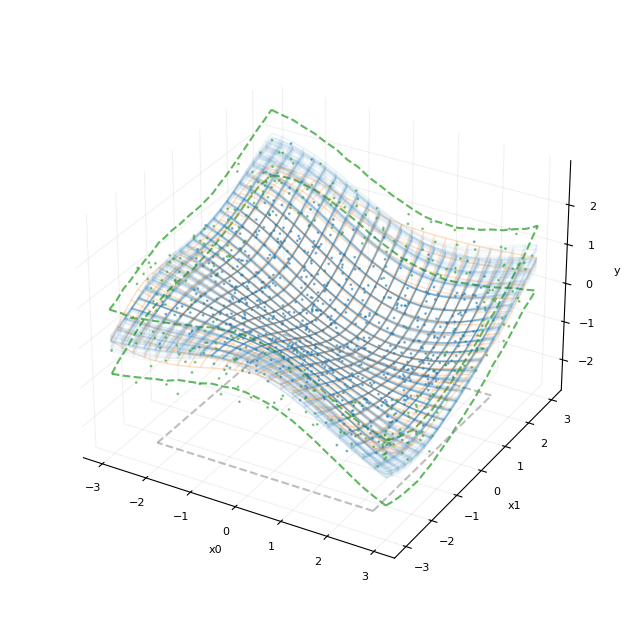

In [80]:
def plot_fit_result(
    N_post: int, post: dict[str, jax.Array], q_lower: float = 0.1, q_upper: float = 0.9
):
    ci = np.quantile(
        posterior_predictive["y_test"], jnp.array([q_lower, q_upper]), axis=0
    )
    if D == 1:
        ci_lower, ci_upper = ci[0, :], ci[1, :]
        test_ind = (X < -L * tr_frac) | (X > L * tr_frac)
        ax = plot_line_scatter(
            X_grid,
            y_grid,
            X,
            y,
            test_ind=test_ind,
            post_y=post["f_star"][0:N_post, :],
            post_alpha=0.1,
            point_alpha=0.15,
            v_lines=[-L * tr_frac, L * tr_frac],
            ci=(ci_lower, ci_upper),
            fig_size=5.0,
        )
    elif D == 2:
        # compute confidence intervals at the edges of the grid
        yz_ind1 = X_grid[:, 0] == L
        yz_lower1 = ci[0, :][yz_ind1]
        yz_upper1 = ci[1, :][yz_ind1]
        yz_ind2 = X_grid[:, 0] == -L
        yz_lower2 = ci[0, :][yz_ind2]
        yz_upper2 = ci[1, :][yz_ind2]

        xz_ind1 = X_grid[:, 1] == L
        xz_lower1 = ci[0, :][xz_ind1]
        xz_upper1 = ci[1, :][xz_ind1]
        xz_ind2 = X_grid[:, 1] == -L
        xz_lower2 = ci[0, :][xz_ind2]
        xz_upper2 = ci[1, :][xz_ind2]

        ax = plot_surface_scatter(
            N_grid=N_grid,
            X_grid=X_grid,
            y_grid=y_grid,
            X=X,
            y=y,
            test_ind=~tr_idx,
            post_y=posterior_predictive["f_star"][0:N_post, :],
            post_alpha=0.05,
            xy_annotate_lines=[
                ((-L * tr_frac, -L * tr_frac), (-L * tr_frac, L * tr_frac)),
                ((-L * tr_frac, L * tr_frac), (L * tr_frac, L * tr_frac)),
                ((L * tr_frac, L * tr_frac), (-L * tr_frac, L * tr_frac)),
                ((L * tr_frac, -L * tr_frac), (-L * tr_frac, -L * tr_frac)),
            ],
            yz_lines=[
                (X_grid[yz_ind1, 1], yz_lower1, L),
                (X_grid[yz_ind1, 1], yz_upper1, L),
                (X_grid[yz_ind2, 1], yz_lower2, -L),
                (X_grid[yz_ind2, 1], yz_upper2, -L),
            ],
            xz_lines=[
                (X_grid[xz_ind1, 0], xz_lower1, L),
                (X_grid[xz_ind1, 0], xz_upper1, L),
                (X_grid[xz_ind2, 0], xz_lower2, -L),
                (X_grid[xz_ind2, 0], xz_upper2, -L),
            ],
            y_wireframe_alpha=0.25,
            ci_alpha=0.75,
        )
    return ax


plot_fit_result(20, posterior_predictive)
plt.show()

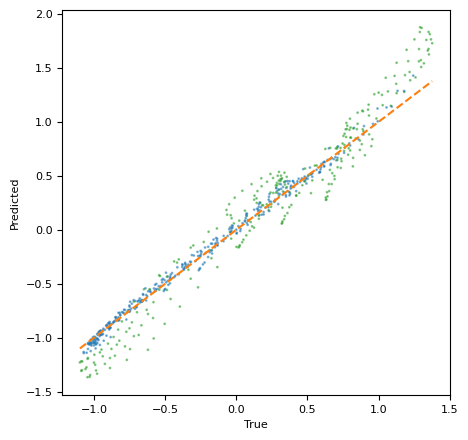

In [95]:
def plot_calibration(
    y_true: jax.Array,
    y_pred: jax.Array,
    test_ind: jax.Array | None = None,
    fig_size: float = 5.0,
    label_size: float = 8.0,
    point_size: float = 1.0,
):
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot()
    color = (
        "tab:blue" if test_ind is None else np.where(test_ind, "tab:green", "tab:blue")
    )
    ax.scatter(y_true, y_pred, c=color, alpha=0.5, s=point_size)
    ax.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        color="tab:orange",
        linestyle="--",
    )
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.set_xlabel("True", fontsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.set_ylabel("Predicted", fontsize=label_size)
    return ax


ax = plot_calibration(
    y_grid,
    posterior_predictive["f_star"].mean(axis=0),
    test_ind=~tr_idx_grid,
    point_size=1.0 if D == 2 else 5.0,
)
plt.show()

In [97]:
posterior_predictive_test = posterior_predictive_svi(
    seed, m.model, guide, res.params, X_test=X_test
)
print(
    "Test RMSE:",
    jnp.sqrt(
        jnp.mean((posterior_predictive_test["y_test"].mean(axis=0) - y_test) ** 2)
    ),
)

Test RMSE: 0.5507755909868102


## HSGP Alternative

In [90]:
def eigv(L: jax.Array, S: jax.Array) -> jax.Array:
    """compute multivariate eigenvalues of the Laplacian

    Parameters
    ----------
    L : jax.Array
        D x 1 array of Dirichlet boundary conditions
    S : jax.Array
        matrix of basis function indices

    Returns
    -------
    jax.Array
        1 x D x m array of eigenvalues
    """
    return ((jnp.pi * S) / (2 * L)) ** 2


def eigf(x: jax.Array, L: jax.Array, S: jax.Array) -> jax.Array:
    """compute multivariate eigenfunctions of the Laplacian

    Parameters
    ----------
    x : jax.Array
        N x D x 1 array of input points
    L : jax.Array
        1 x D x 1 array of Dirichlet boundary conditions
    S : jax.Array
        matrix of basis function indices

    Returns
    -------
    jax.Array
        N x m array of eigenfunction output
    """
    return jnp.prod(jnp.sqrt(1 / L) * jnp.sin(jnp.sqrt(eigv(L, S)) * (x + L)), axis=1)


def s_inf(omega: jax.Array, D: int, amplitude: float, lengthscale: float) -> jax.Array:
    """compute spectral density of squared exponential covariance function

    Parameters
    ----------
    omega : jax.Array
        N x D x m array of eigenvalue inputs
    D : int
        dimensionality of input space
    amplitude : float
        amplitude of the covariance function
    lengthscale : float
        lengthscale of the covariance function

    Returns
    -------
    jax.Array
        m vector of spectral densities
    """
    return (
        amplitude
        * (jnp.sqrt(2 * jnp.pi)) ** D
        * lengthscale**D
        * jnp.exp(-0.5 * lengthscale**2 * (omega**2).sum(axis=1))
    )


def hsgp_f(
    x: jax.Array,
    beta: jax.Array,
    m: int,
    L: jax.Array,
    S: jax.Array,
    amplitude: float,
    lengthscale: float,
) -> float:
    """compute the function approximation

    Parameters
    ----------
    x : jax.Array
        N x D x 1 set of points in function preimage
    beta : jax.Array
        1 x 1 x m array of coefficients
    m : int
        number of basis functions in the approximation
    L : jax.Array
        1 x D x 1 array of Dirichlet boundary conditions
    amplitude : float
        amplitude of the covariance function
    lengthscale : float
        lengthscale of the covariance function

    Returns
    -------
    float
        function approximation value
    """
    D = L.shape[1]
    return jnp.sum(
        jnp.sqrt(s_inf(jnp.sqrt(eigv(L, S)), D, amplitude, lengthscale))
        * eigf(x, L, S)
        * beta,
        axis=-1,
    )

In [91]:
from itertools import product


@jax.tree_util.register_pytree_node_class
class HSGPModel:
    def __init__(self, m: int, D: int, L: float) -> None:
        self.m = m
        self.D = D
        self.L = jnp.repeat(L, D)[None, ..., None]
        self.S = jnp.array(
            [list(x) for x in product(list(range(1, m + 1)), repeat=D)]
        ).T[None, ...]

    def model(
        self,
        X: jax.Array,
        y: jax.Array | None = None,
    ):
        amplitude = numpyro.sample("amplitude", dist.LogNormal(0, 1))
        length = numpyro.sample("lengthscale", dist.Exponential(1))
        noise = numpyro.sample("noise", dist.LogNormal(0, 1))

        beta = numpyro.sample("beta", dist.Normal(jnp.zeros(self.m**self.D), 1))[
            None, ...
        ]
        f = numpyro.deterministic(
            "f_star",
            hsgp_f(X[..., None], beta, self.m, self.L, self.S, amplitude, length),
        )
        site = "y" if y is not None else "y_test"
        numpyro.sample(site, dist.Normal(f, noise), obs=y)

    def tree_flatten(self):
        children = (self.L, self.S)  # arrays / dynamic values
        aux_data = (self.m, self.D)  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

In [127]:
hsgp_m = HSGPModel(m=10, D=D, L=L * 2.0)
hsgp_guide = AutoNormal(hsgp_m.model, init_loc_fn=init_to_median(num_samples=25))
hsgp_res = fit_svi(seed, hsgp_m.model, hsgp_guide, X=X_tr, y=y_tr, num_steps=10000)

100%|██████████| 10000/10000 [00:22<00:00, 442.53it/s, init loss: 1234.3765, avg. loss [9501-10000]: 526.2373]


In [128]:
posterior_predictive_hsgp = posterior_predictive_svi(
    seed,
    hsgp_m.model,
    hsgp_guide,
    hsgp_res.params,
    X=X_grid,
)

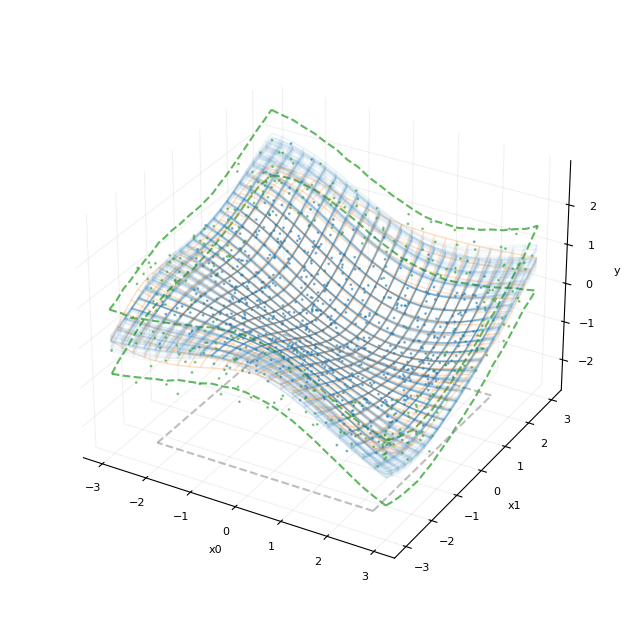

In [129]:
plot_fit_result(20, posterior_predictive_hsgp)
plt.show()

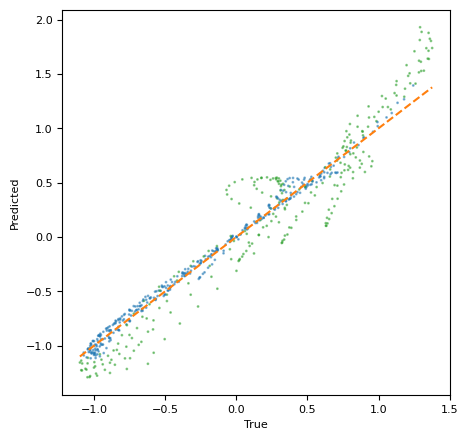

In [130]:
ax = plot_calibration(
    y_grid,
    posterior_predictive_hsgp["f_star"].mean(axis=0),
    test_ind=~tr_idx_grid,
    point_size=1.0 if D == 2 else 5.0,
)
# TODO customize labels

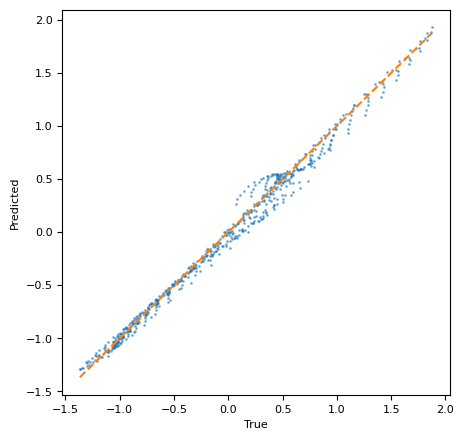

In [131]:
ax = plot_calibration(
    posterior_predictive["f_star"].mean(axis=0),
    posterior_predictive_hsgp["f_star"].mean(axis=0),
    point_size=1.0 if D == 2 else 5.0,
)

In [133]:
posterior_predictive_test_hsgp = posterior_predictive_svi(
    seed, hsgp_m.model, hsgp_guide, hsgp_res.params, X=X_test
)
print(
    "Test RMSE:",
    jnp.sqrt(
        jnp.mean((posterior_predictive_test_hsgp["y_test"].mean(axis=0) - y_test) ** 2)
    ),
)

Test RMSE: 0.5639001139944279


In [ ]:
# TODO clean up refs

**References**

1. Lawrence 2005 https://www.jmlr.org/papers/volume6/lawrence05a/lawrence05a.pdf
2. Titsias 2009 https://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf
3. Titsias and Lawrence 2010 https://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf
4. Lalchand Ravuri and Lawrence 2022 https://proceedings.mlr.press/v151/lalchand22a/lalchand22a.pdf
5. Pyro GP-LVM https://pyro.ai/examples/gplvm.html
6. https://github.com/OleguerCanal/GPLVM
7. Ruitort-Mayol et al 2020 https://arxiv.org/abs/2004.11408
8. Solin and Särkkä 2020 https://robotics.caltech.edu/wiki/images/2/2d/ReducedRankGPR.pdf 

In [134]:
# warmup -- practice on a synthetic 2d gaussian surface. test error rate of approximation against full gp inference
# multidim stan implementation here https://github.com/gabriuma/basis_functions_approach_to_GP/blob/master/multi_dimensional/diabetes_dataset/model_BF_multi.stan
# Orduz pymc https://github.com/juanitorduz/website_projects/blob/master/Python/hsgp_intro.ipynb
# https://juanitorduz.github.io/hsgp_intro/
# https://juanitorduz.github.io/the-spectral-theorem-for-matrices/
# really nice nb: https://github.com/omarfsosa/hsgp/blob/master/notebooks/gp-approximation.ipynb (try to replicate the plots in 3d?)
# https://matplotlib.org/stable/gallery/mplot3d/wire3d.html
# variational HSGP? https://arxiv.org/pdf/1711.10127
# Stein Variational GPs https://arxiv.org/abs/2009.12141

# contribute multidim example first, then onto HSGPLVM
# TODO address this, 2d extension, perhaps we can extend contrib module later
# https://github.com/pyro-ppl/numpyro/pull/1794/files